In [36]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aero_design_functions import *
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc, load_oper
from lacbox.test import test_data_path
from myteampack import MyHTC
from Our_values import *
from scipy.interpolate import interp1d


In [13]:
# data

R = R_Y
r_hub = r_hub
R_X = R_X


scale = (R_Y - r_hub)/(R_X - r_hub)
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]

chord_root = 5.38  # Chord size at the root [m]
chord_max = 6.3

tsr = 7.2631578947368425
B = 3  # Number of blades [#]

Data_ae = load_ae("DTU_10MW_RWT_ae.dat")
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
abs_t=data_ae["chord"]*data_ae["rel_th"]/100*R_Y/R_X # new thickness
abs_t[0:2]=data_ae["chord"][0:2]
abs_t[2]=0.99*abs_t[2]
t = abs_t # Absolute thickness [m]


cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)



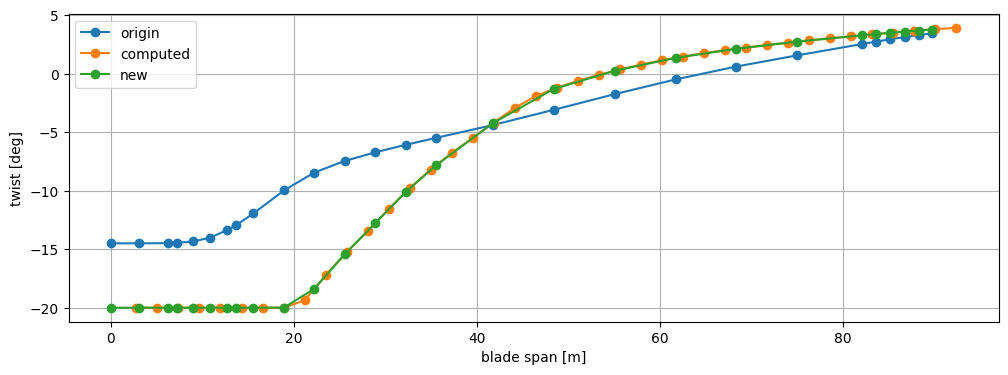

40


In [14]:
# to modify input hawc file, usefull printing statement


# modifations of _master/Group1_redesign.htc

original_z = np.array([4.44089E-16,
                    3.00000E+00,
                    6.00000E+00,
                    7.00004E+00,
                    8.70051E+00,
                    1.04020E+01,
                    1.22046E+01,
                    1.32065E+01,
                    1.50100E+01,
                    1.82151E+01,
                    2.14178E+01,
                    2.46189E+01,
                    2.78193E+01,
                    3.10194E+01,
                    3.42197E+01,
                    4.02204E+01,
                    4.66217E+01,
                    5.30232E+01,
                    5.94245E+01,
                    6.58255E+01,
                    7.22261E+01,
                    7.90266E+01,
                    8.05267E+01,
                    8.20271E+01,
                    8.35274E+01,
                    8.50277E+01,
                    8.63655E+01])

new_z = original_z*scale

#for element in new_z:
#    print(f"{element:.5E}")

original_twist = np.array([
    -1.45000E+01,
    -1.45000E+01,
    -1.44851E+01,
    -1.44610E+01,
    -1.43388E+01,
    -1.40201E+01,
    -1.33904E+01,
    -1.29371E+01,
    -1.19445E+01,
    -9.98243E+00,
    -8.45147E+00,
    -7.46417E+00,
    -6.72916E+00,
    -6.08842E+00,
    -5.49322E+00,
    -4.39222E+00,
    -3.09315E+00,
    -1.75629E+00,
    -5.00650E-01,
    6.01964E-01,
    1.55560E+00,
    2.51935E+00,
    2.72950E+00,
    2.93201E+00,
    3.11874E+00,
    3.28847E+00,
    3.42796E+00])

new_twist = -np.interp(new_z, r, twist)             # minus sign to be consistent with htc

plt.figure(figsize=(12,4))
plt.plot(new_z, original_twist, marker='o', label='origin')
plt.plot(r, -twist, marker='o', label='computed')
plt.plot(new_z, new_twist, marker='o', label='new')
plt.xlabel('blade span [m]')
plt.ylabel('twist [deg]')
plt.grid()
plt.legend()
plt.show()

#for element in new_twist:
#    print(f"{element:.5E}")


# modifications of data/DTU_10MW_RWT_ae.dat 
new_curve = r - r_hub

#for element in new_curve:
#    print(f"{element:.5E}")

#for element in chord:
#    print(f"{element:.5E}")

#for element in tc:
#    print(f"{element:.5E}")
print(len(tc))


In [15]:
# compute omega rated

V_rated_Y = 11.122788574520852
R_Y = 92.52423873190985
TSR_opt = 7.2631578947368425

omega_max = TSR_opt * V_rated_Y / R_Y * 60 / (2*np.pi)
print('omega_max', omega_max)

omega_max 8.337868262998404


RUN HAW2s 1ws 

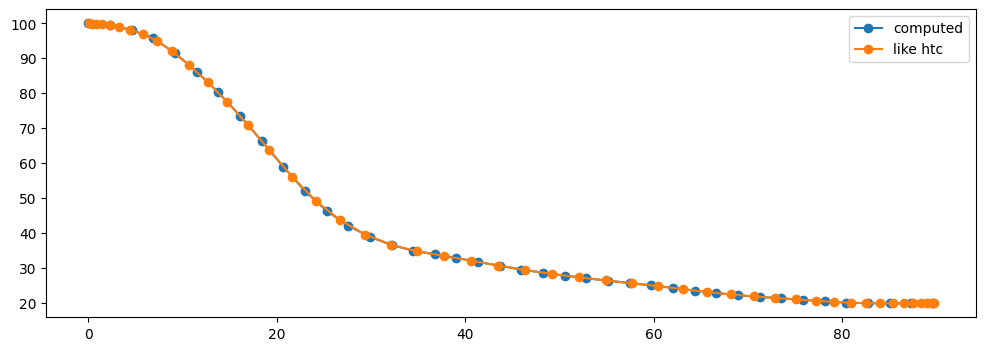

r [62.82371631 44.94283655 33.13892455 24.71409039]


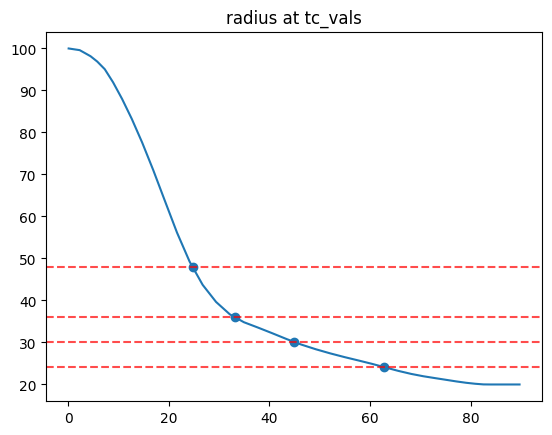

In [22]:
# open induction files
ind_data_path = 'hawc_files/our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind'
ind_data_DTU_10_path = 'hawc_files/dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind'

ind_data = load_ind(ind_data_path)
ind_data_DTU_10 = load_ind(ind_data_DTU_10_path)

# Print the names in the dict
#print(ind_data.keys())

alpha_redesign = np.rad2deg(ind_data['aoa_rad'])
Cl_redesign = ind_data['Cl']
Cd_redesign = ind_data['Cd']
CP_redesign = ind_data['CP']
CT_redesign = ind_data['CT']
r_redesign = ind_data["s_m"]

alpha_DTU_10 = np.rad2deg(ind_data['aoa_rad'])
Cl_DTU_10 = ind_data_DTU_10['Cl']
Cd_DTU_10 = ind_data_DTU_10['Cd']
CP_DTU_10 = ind_data_DTU_10['CP']
CT_DTU_10 = ind_data_DTU_10['CT']
r_DTU_10 = ind_data_DTU_10["s_m"]

# our data
r_analytical = r - r_hub
Cl_analytical = cl
Cd_analytical = cd
alpha_analytical = aoa
a_analytical = a
CP_analytical = CLP
CT_analytical = CLT

# Side-by-side plots of the HAWC2S lift coefficient and the design lift coefficient versus relative
# thickness (left plot) and versus radius (right plot) for design pitch and design TSR. The same should be
# done for the lift-drag ratio and AoA. Thus, curves plotted in section 2 are repeated in the plots for the
# relative thickness

# get tc to the number of nodes of HAWC2S files

cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, TSR_opt, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)

new_tc = np.interp(r_redesign, r_analytical, tc)
plt.figure(figsize=(12,4))
plt.plot(r_analytical, tc,  marker='o', label='computed')
plt.plot(r_redesign, new_tc,  marker='o', label='like htc')
plt.legend()
plt.show()


# Find the radius (r_redesign) that corresponds to each thickness (tc_points)
# sorted otherwise does not work
sorted_indices = np.argsort(new_tc)
sorted_new_tc = new_tc[sorted_indices]
sorted_r_redesign = r_redesign[sorted_indices]
r_points_redesign = np.interp(tc_vals, sorted_new_tc, sorted_r_redesign)
print('r', r_points_redesign)

plt.figure()
plt.title('radius at tc_vals')
plt.plot(r_redesign, new_tc)
for y in tc_vals:
    plt.axhline(y=y, color='r', linestyle='--', alpha=0.7)
plt.scatter(r_points_redesign, tc_vals)

# find Cl and alpha for the new radius corresponding to tc_vals
sorted_indices = np.argsort(r_redesign)
sorted_r_redesign = r_redesign[sorted_indices]
sorted_Cl_redesign = Cl_redesign[sorted_indices]
sorted_Cd_redesign = Cd_redesign[sorted_indices]
sorted_alpha_redesign = alpha_redesign[sorted_indices]
Cl_points_redesign = np.interp(r_points_redesign, sorted_r_redesign, sorted_Cl_redesign)
Cd_points_redesign = np.interp(r_points_redesign, sorted_r_redesign, sorted_Cd_redesign)
alpha_points_redesign = np.interp(r_points_redesign, sorted_r_redesign, sorted_alpha_redesign)


# get approximated data, just to check
tc_indexes = [30, 23, 19, 16]
tc_vals_approx = new_tc[tc_indexes]
r_points_redesign_approx = r_redesign[tc_indexes]
Cl_points_redesign_approx = Cl_redesign[tc_indexes]
alpha_points_redesign_approx = alpha_redesign[tc_indexes]

# data from part 2
Data_cl = load_pc("DTU_10MW_RWT_pc.dat") # return a list per blade
n = len(Data_cl)-2 # exclude airfoils of 100% and 60% relative thickness
des_param = np.zeros((4,n)) # relative thickness, cl design, cd design, AoA design
arg_0 = [63,63,63,58] # indices of the AoAs before stall

for k in range(n):
    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - 0.4

    # Finding corresponding AoA
    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]

cl_des1, cd_des1, aoa_des1, tc_vals1, cl_vals1, cd_vals1, aoa_vals1 = get_design_functions(1)
cl_des2, cd_des2, aoa_des2, tc_vals2, cl_vals2, cd_vals2, aoa_vals2 = get_design_functions(2)
cl_des3, cd_des3, aoa_des3, tc_vals3, cl_vals3, cd_vals3, aoa_vals3 = get_design_functions(3)


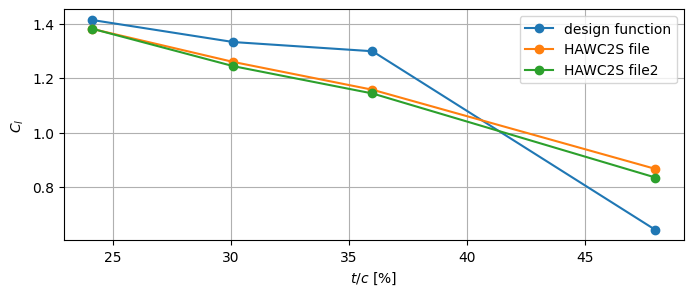

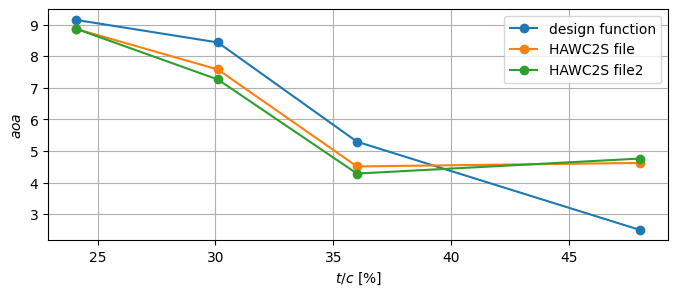

In [17]:
# Cl versis tc
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
#ax.plot(des_param[0,:], des_param[1,:], marker='o', label="computed")
ax.plot(tc_vals, cl_vals, marker='o', label="design function")
ax.plot(tc_vals, Cl_points_redesign, marker='o', label="HAWC2S file")
ax.plot(tc_vals2, Cl_points_redesign_approx, marker='o', label="HAWC2S file2")
ax.set_xlabel('${t/c}$ [%]')
ax.set_ylabel('$C_l$')
ax.legend()
ax.grid()

# alpha versus tc
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
#ax.plot(des_param[0,:], des_param[3,:], marker='o', label="computed")
ax.plot(tc_vals, aoa_vals, marker='o', label="design function")
ax.plot(tc_vals, alpha_points_redesign, marker='o', label="HAWC2S file")
ax.plot(tc_vals2, alpha_points_redesign_approx, marker='o', label="HAWC2S file2")
ax.set_xlabel('${t/c}$ [%]')
ax.set_ylabel('$aoa$')
ax.legend()
ax.grid()

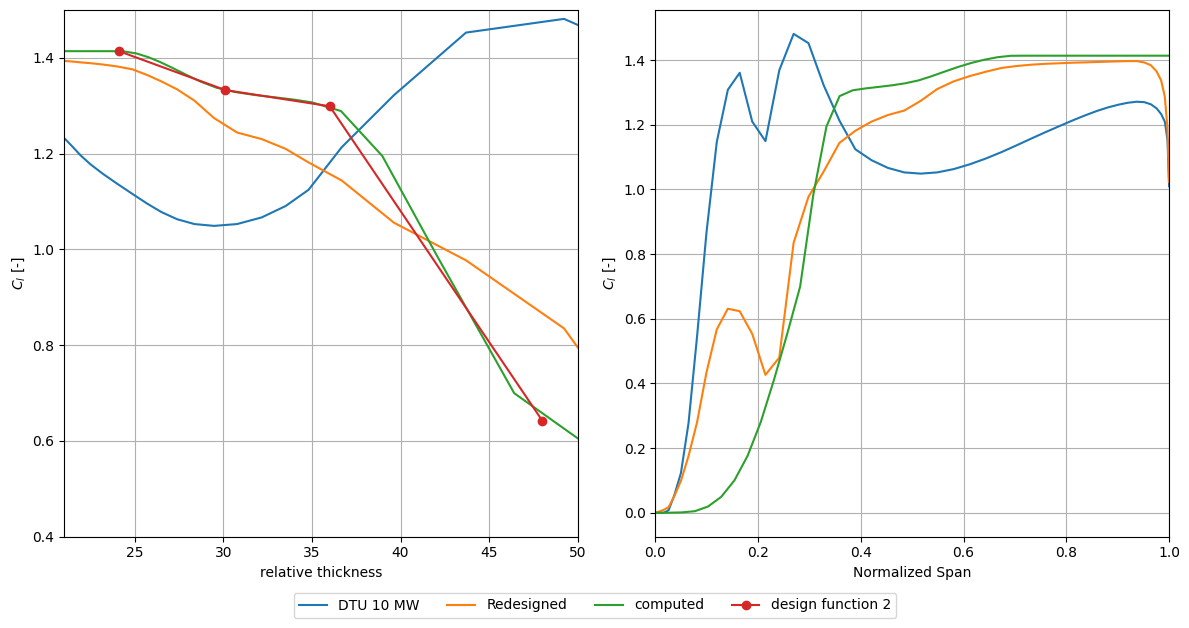

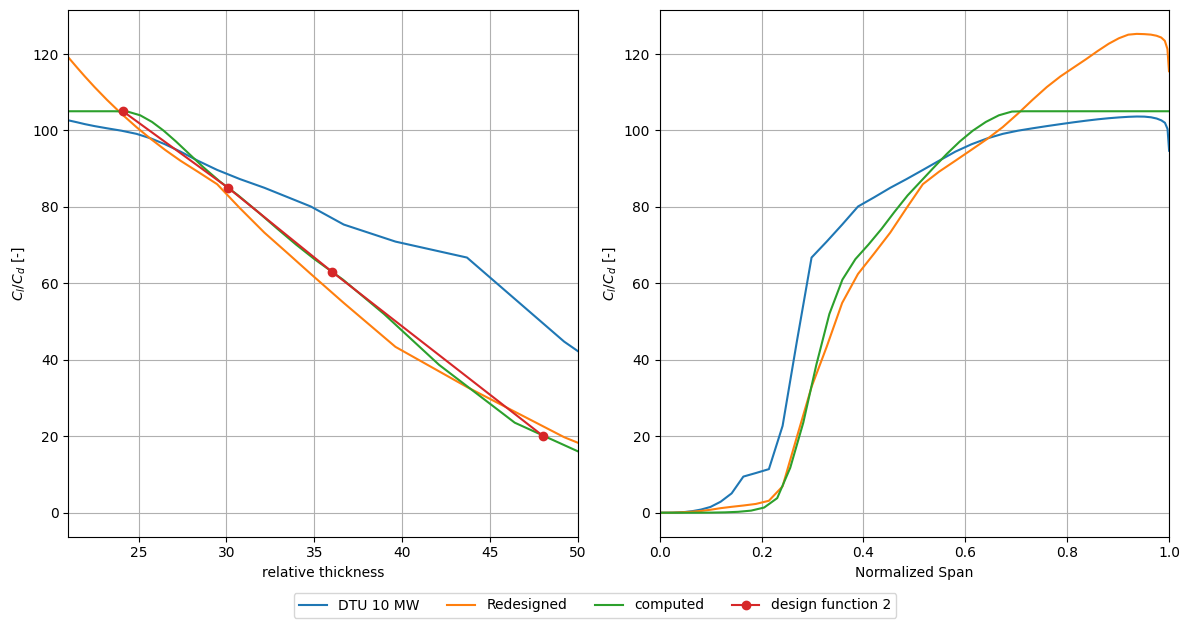

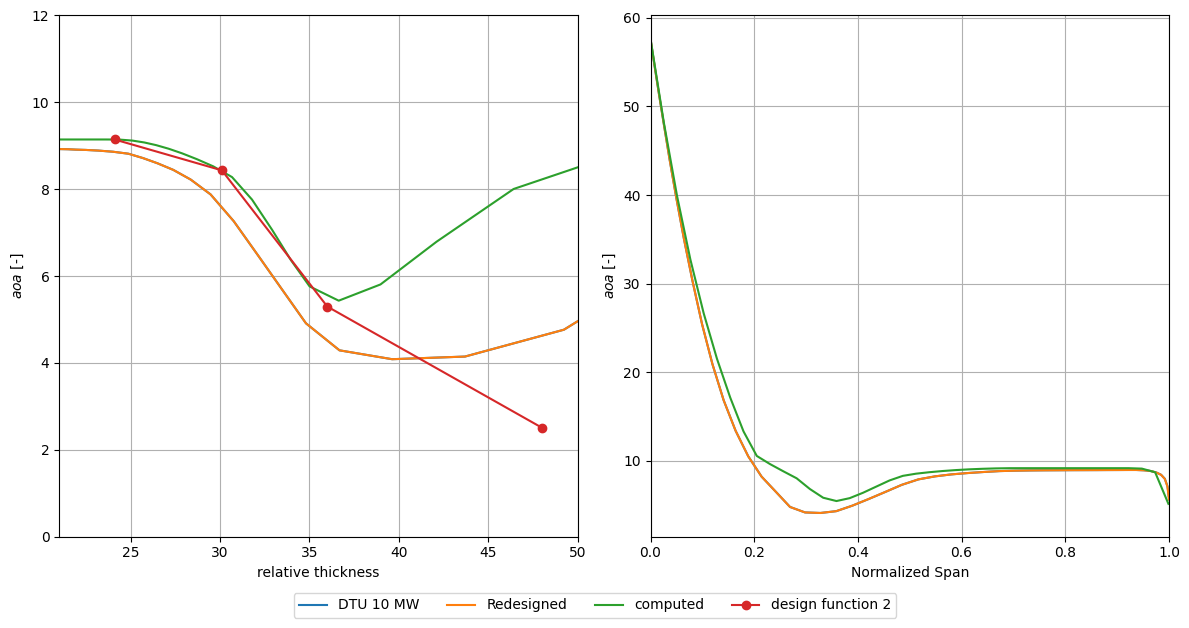

In [18]:
# first plot for part 3. not looking good

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6), num=1, clear=True)  # Adjust figure size for better spacing
#fig2.subplots_adjust(vspace=0.4)  # Increase the space between the plots

# Plot Cl
axs1[0].plot(new_tc, Cl_DTU_10, label='DTU 10 MW')
axs1[0].plot(new_tc, Cl_redesign, label='Redesigned')
axs1[0].plot(tc, Cl_analytical, label='computed')
#axs1[0].plot(tc_vals1, cl_vals1, marker='o', label="design function 1")
axs1[0].plot(tc_vals2, cl_vals2, marker='o', label="design function 2")
#axs1[0].plot(tc_vals3, cl_vals3, marker='o', label="design function 3")
#axs1[0].plot(tc_vals, Cl_points_redesign, marker='o', label="HAWC2S file")
axs1[0].set_ylabel("$C_l$ [-]")
#axs1[0].set_xlim(0, 100)
axs1[0].set_xlim(21, 50)
axs1[0].set_ylim(0.4, 1.5)
axs1[0].set_xlabel("relative thickness")
axs1[0].grid(True)  # Add grid

axs1[1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10)
axs1[1].plot(r_redesign/(R_Y-r_hub), Cl_redesign)
axs1[1].plot(r_analytical/(R_Y-r_hub), Cl_analytical)
axs1[1].set_ylabel("$C_l$ [-]")
axs1[1].set_xlabel("Normalized Span") 
axs1[1].set_xlim(0, 1)
axs1[1].grid(True)  # Add grid
plt.tight_layout()
fig1.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
plt.show()


# Plot Cl/Cd
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 6), num=1, clear=True)
axs2[0].plot(new_tc, Cl_DTU_10/Cd_DTU_10, label='DTU 10 MW')
axs2[0].plot(new_tc, Cl_redesign/Cd_redesign, label='Redesigned')
axs2[0].plot(tc, Cl_analytical/Cd_analytical, label='computed')
#axs2[0].plot(tc_vals1, cl_vals1/cd_vals1, marker='o', label="design function 1")
axs2[0].plot(tc_vals2, cl_vals2/cd_vals2, marker='o', label="design function 2")
#axs2[0].plot(tc_vals3, cl_vals3/cd_vals3, marker='o', label="design function 3")
axs2[0].set_ylabel("$C_l/C_d$ [-]")
#axs2[0].set_xlim(0, 100)
axs2[0].set_xlim(21, 50)
axs2[0].set_xlabel("relative thickness")
axs2[0].grid(True)  # Add grid

axs2[1].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10/Cd_DTU_10)
axs2[1].plot(r_redesign/(R_Y-r_hub), Cl_redesign/Cd_redesign)
axs2[1].plot(r_analytical/(R_Y-r_hub), Cl_analytical/Cd_analytical)
axs2[1].set_ylabel("$C_l/C_d$ [-]")
axs2[1].set_xlabel("Normalized Span") 
axs2[1].set_xlim(0, 1)
axs2[1].grid(True)  # Add grid
plt.tight_layout()
fig2.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
plt.show()


# Plot alpha
fig3, axs3 = plt.subplots(1, 2, figsize=(12, 6), num=1, clear=True)
axs3[0].plot(new_tc, alpha_DTU_10, label='DTU 10 MW')
axs3[0].plot(new_tc, alpha_redesign, label='Redesigned')
axs3[0].plot(tc, alpha_analytical, label='computed')
axs3[0].plot(tc_vals2, aoa_vals2, marker='o', label="design function 2")
axs3[0].set_ylabel("$aoa$ [-]")
axs3[0].set_xlim(21, 50)
axs3[0].set_ylim(0, 12)
axs3[0].set_xlabel("relative thickness")
axs3[0].grid(True)  # Add grid

axs3[1].plot(r_DTU_10/(R_X-r_hub), alpha_DTU_10)
axs3[1].plot(r_redesign/(R_Y-r_hub), alpha_redesign)
axs3[1].plot(r_analytical/(R_Y-r_hub), alpha_analytical)
axs3[1].set_ylabel("$aoa$ [-]")
axs3[1].set_xlabel("Normalized Span") 
axs3[1].set_xlim(0, 1)
axs3[1].grid(True)  # Add grid
plt.tight_layout()
fig3.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
plt.show()



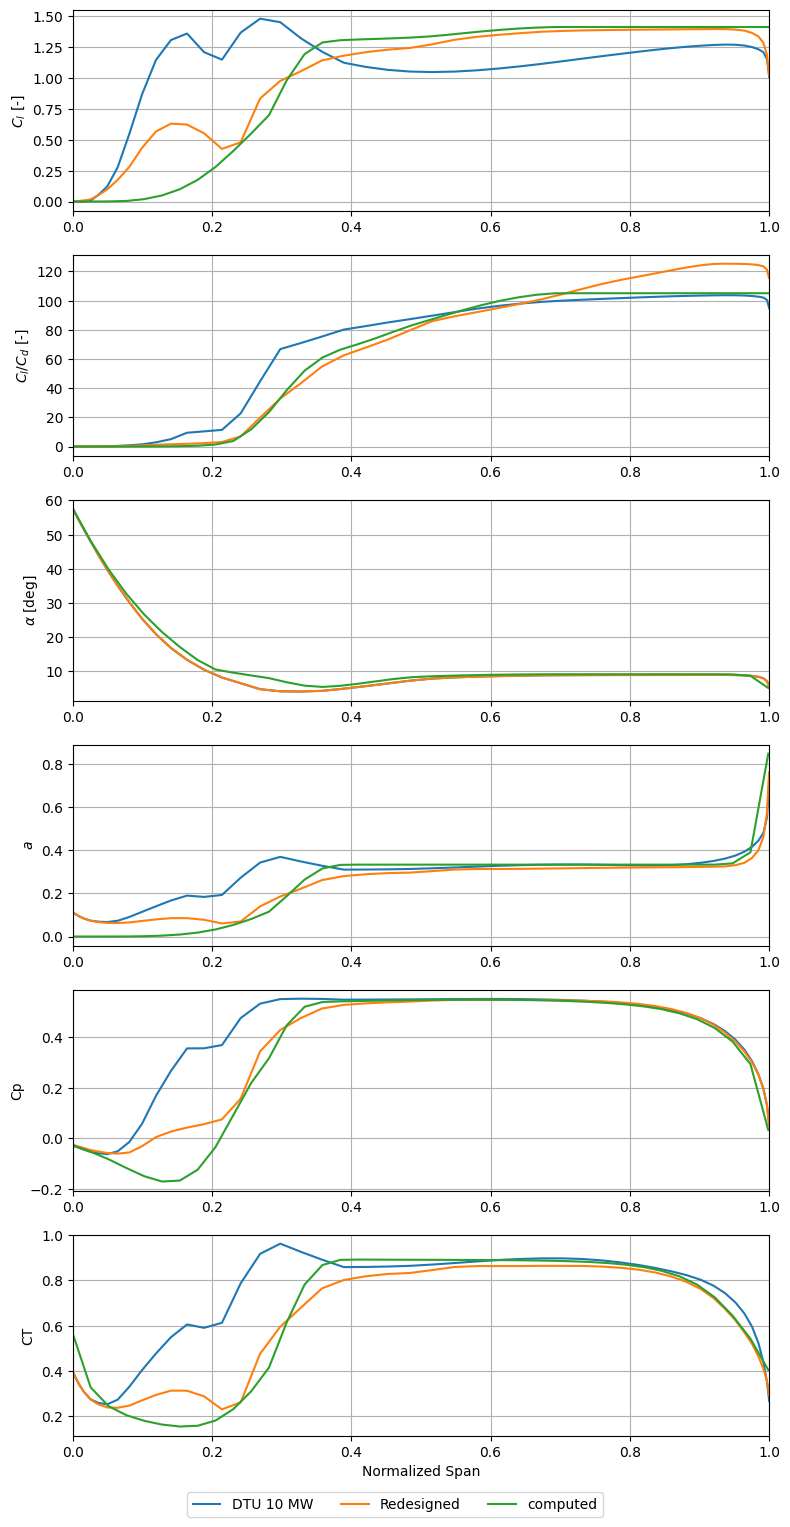

In [19]:
# quantities as a function of radius, looks good

# Create subplots with increased vertical spacing
fig1, axs1 = plt.subplots(6, 1, num=1, clear=True, figsize=(8, 15))  # Adjust figure size for better spacing
fig1.subplots_adjust(hspace=0.4)  # Increase the space between the plots

# Plot Cl
axs1[0].plot(r_DTU_10/(R_X-r_hub), Cl_DTU_10, label='DTU 10 MW')
axs1[0].plot(r_redesign/(R_Y-r_hub), Cl_redesign, label='Redesigned')
axs1[0].plot(r_analytical/(R_Y-r_hub), Cl_analytical, label='computed')
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].set_xlim(0, 1)
axs1[0].grid(True)  # Add grid

# Plot Cl / Cd
axs1[1].plot(r_DTU_10/(R_X-r_hub), (Cl_DTU_10 / Cd_DTU_10))
axs1[1].plot(r_redesign/(R_Y-r_hub), (Cl_redesign / Cd_redesign))
axs1[1].plot(r_analytical/(R_Y-r_hub), (Cl_analytical/Cd_analytical))
axs1[1].set_ylabel("$C_l / C_d$ [-]")
axs1[1].set_xlim(0, 1)
axs1[1].grid(True)  # Add grid

# Plot AoA with label
axs1[2].plot(r_DTU_10/(R_X-r_hub), alpha_DTU_10)
axs1[2].plot(r_redesign/(R_Y-r_hub), alpha_redesign)
axs1[2].plot(r_analytical/(R_Y-r_hub), alpha_analytical)
axs1[2].set_ylabel(r"$\alpha$ [deg]")
axs1[2].set_xlim(0, 1)
axs1[2].grid(True)  # Add grid


axs1[3].plot(r_DTU_10/(R_X-r_hub), ind_data_DTU_10["a"])
axs1[3].plot(r_redesign/(R_Y-r_hub), ind_data["a"])
axs1[3].plot(r_analytical/(R_Y-r_hub), a_analytical)
axs1[3].set_ylabel(r"$a$")
axs1[3].set_xlim(0, 1)
axs1[3].grid(True)  # Add grid

axs1[4].plot(r_DTU_10/(R_X-r_hub), ind_data_DTU_10["CP"])
axs1[4].plot(r_redesign/(R_Y-r_hub), ind_data["CP"])
axs1[4].plot(r_analytical/(R_Y-r_hub), CP_analytical)
axs1[4].set_ylabel('Cp')
axs1[4].set_xlim(0, 1)
axs1[4].grid(True)  # Add grid

axs1[5].plot(r_DTU_10/(R_X-r_hub), ind_data_DTU_10["CT"])
axs1[5].plot(r_redesign/(R_Y-r_hub), ind_data["CT"])
axs1[5].plot(r_analytical/(R_Y-r_hub), CT_analytical)
axs1[5].set_ylabel('CT')
axs1[5].set_xlabel("Normalized Span")  # Add label for the last plot
axs1[5].set_xlim(0, 1)
axs1[5].grid(True)  # Add grid

plt.tight_layout()
# Move the legend to the bottom of the figure and apply it to all plots
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
# Show the plot
plt.show()

RUN HAW2s multiws (actually multy TSR, constant speed and changing omega)

In [43]:
# compute omega for redesign
# V_rated_Y = 11.12278

TSR_range = np.arange(5.5,10.5,0.2)
print('number of lines', len(TSR_range))

V_rated_Y_range = np.arange(V_rated_Y, V_rated_Y + len(TSR_range) * 0.001 - 0.001, 0.001)

omega_range = TSR_range * V_rated_Y_range / R_Y * 60 / (2*np.pi)

#for element in V_rated_Y_range:
#    print(f"{element:.6f}")

#for element in omega_range:
#    print(f"{element:.6f}")


# for pmega for DTU 10 MW
V_rated_X_range = np.arange(V_rated_X, V_rated_X + len(TSR_range) * 0.001 - 0.001, 0.001)
omega_range_X = TSR_range * V_rated_X_range/ R_X * 60 / (2*np.pi)

#for element in V_rated_X_range:
#    print(f"{element:.6f}")

for element in omega_range_X:
    print(f"{element:.6f}")

number of lines 25
6.715353
6.960158
7.205006
7.449897
7.694831
7.939807
8.184827
8.429889
8.674994
8.920142
9.165333
9.410566
9.655843
9.901162
10.146524
10.391929
10.637377
10.882867
11.128401
11.373977
11.619596
11.865258
12.110963
12.356711
12.602501


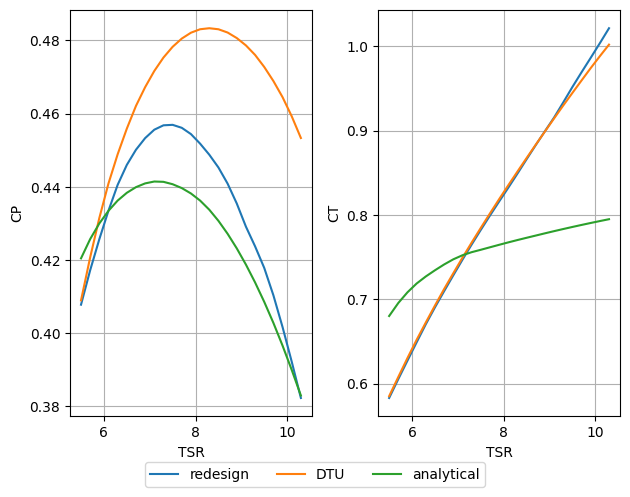

In [50]:
# Side-by-side plots of the power and thrust coefficients calculated with HAWC2S at design pitch versus TSR

pwr_path = "hawc_files/our_design/res_hawc2s/Group1_redesign_hawc2s_multiwsp.pwr"
pwr_data = load_pwr(pwr_path)

pwr_path_DTU_10_MW = "hawc_files/dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_multiwsp.pwr"
pwr_data_DTU_10_MW = load_pwr(pwr_path_DTU_10_MW)


CP_list = []
CT_list = []
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

for tsr in TSR_range:
    # %% Solving for the a single design
    chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
        r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
    CP_list.append(CP)
    CT_list.append(CT)

CP_array = np.array(CP_list)
CT_array = np.array(CT_list)

fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(TSR_range, pwr_data["Cp"], label='redesign')
axs1[0].plot(TSR_range, pwr_data_DTU_10_MW["Cp"], label='DTU')
axs1[0].plot(TSR_range, CP_array, label='analytical')
axs1[0].set_xlabel("TSR")
axs1[0].set_ylabel("CP")
axs1[0].grid(True)
#axs1[0].set_xlim(min(TSR_range), max(TSR_range))

axs1[1].plot(TSR_range, pwr_data["Ct"])
axs1[1].plot(TSR_range, pwr_data_DTU_10_MW["Ct"])
axs1[1].plot(TSR_range, CT_array)
axs1[1].set_xlabel("TSR")
axs1[1].set_ylabel("CT")
axs1[1].grid(True)
#axs1[1].set_xlim(min(TSR_range), max(TSR_range))

# Adjust layout and show the figure
plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.04))
plt.savefig('CP_CT_multiple', dpi=600)
plt.show()


[ 1.56059350e+00  1.56059332e+00  1.56059327e+00  1.56059330e+00
  1.56059328e+00  1.56059328e+00  1.56059328e+00  1.44541969e+00
  1.29687188e+00  1.12521182e+00  2.28718158e-01  9.45085742e-03
 -1.13697627e-02 -5.87381562e-03  1.49698189e-02  1.88055883e-02
 -1.55348376e-02  2.98891127e-02  1.47757195e-03 -1.25729685e-02
  1.97737335e-02 -7.05586190e-03 -6.55807588e-02 -1.48011719e-02
  2.27612826e-02  3.68902668e-02  4.48976144e-03  3.97592403e-01
  5.34068411e-02  6.21111863e-02  4.30197253e-03]
dict_keys(['ws_ms', 'pitch_deg', 'rotor_speed_rpm', 'power_kw', 'thrust_kn'])


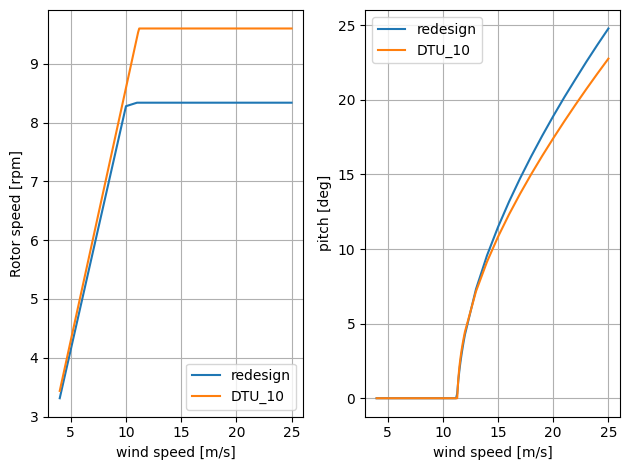

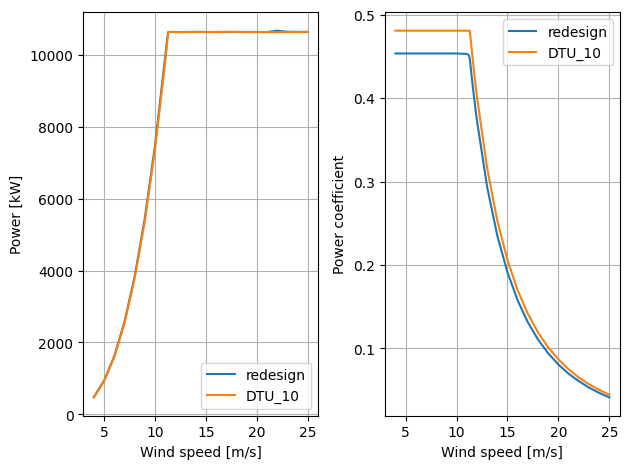

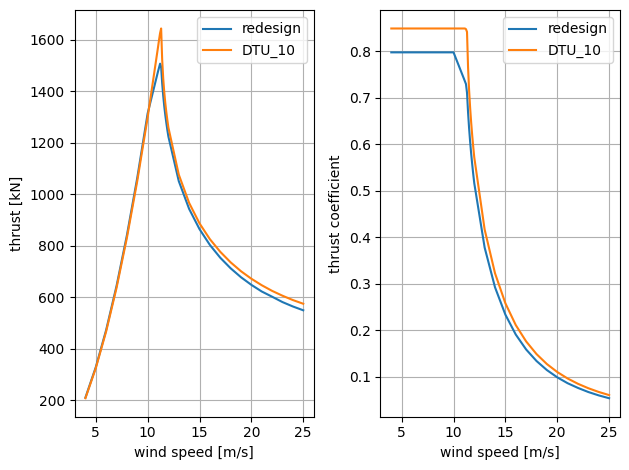

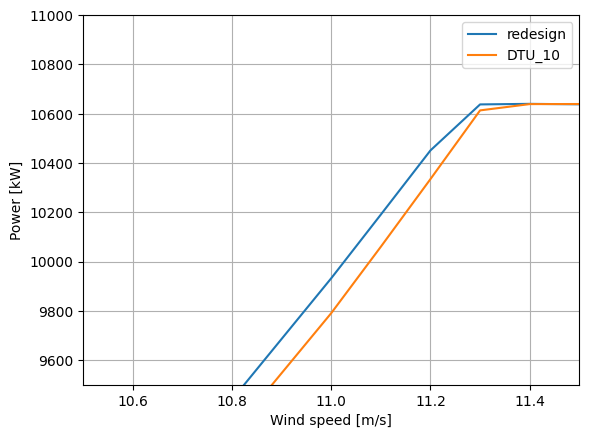

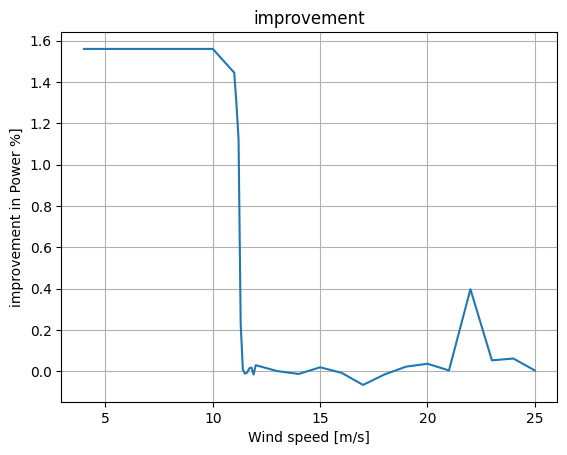

In [10]:
# Side-by-side plots of the rotor speed (left plot) and pitch angles (right plot) versus wind speed

rigid_path = "hawc_files/our_design/data/Group1_redesign_rigid.opt"
rigid_data = load_oper(rigid_path)

rigid_DTU_10_path = "hawc_files/our_design/data/dtu_10mw_rigid.opt"
rigid_DTU_10_data = load_oper(rigid_DTU_10_path)

# power improvement
imp = (rigid_data['power_kw'] - rigid_DTU_10_data['power_kw']) / rigid_DTU_10_data['power_kw']*100
print(imp)


print(rigid_data.keys())


fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(rigid_data['ws_ms'], rigid_data['rotor_speed_rpm'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['rotor_speed_rpm'], label='DTU_10')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("Rotor speed [rpm]")
axs1[0].legend()
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], rigid_data['pitch_deg'], label='redesign')
axs1[1].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['pitch_deg'], label='DTU_10')
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("pitch [deg]")
axs1[1].legend()
axs1[1].grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


# Side-by-side plots of the aerodynamic power (left plot) and its coefficient (right plot), and the thrust (left plot) and its coefficient (right plot) versus wind speed

# power and thrust coefficients
# Cp = P / (1/2 * rho * V0**3 * A)
# Ct = T / (1/2 * rho * V0**2 * A)
rho = 1.225
CP_redesign = rigid_data['power_kw'] / (0.5 * rho * rigid_data['ws_ms']**3 * np.pi*R_Y**2)*1e3
CP_DTU_10 = rigid_DTU_10_data['power_kw'] / (0.5 * rho * rigid_DTU_10_data['ws_ms']**3 * np.pi*R_X**2)*1e3

CT_redesign = rigid_data['thrust_kn'] / (0.5 * rho * rigid_data['ws_ms']**2 * np.pi*R_Y**2)*1e3
CT_DTU_10 = rigid_DTU_10_data['thrust_kn'] / (0.5 * rho * rigid_DTU_10_data['ws_ms']**2 * np.pi*R_X**2)*1e3


fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(rigid_data['ws_ms'], rigid_data['power_kw'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['power_kw'], label='DTU_10')
axs1[0].set_ylabel("Power [kW]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].legend()
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], CP_redesign, label='redesign')
axs1[1].plot(rigid_DTU_10_data['ws_ms'], CP_DTU_10, label='DTU_10')
axs1[1].set_ylabel("Power coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].legend()
axs1[1].grid(True)


# Adjust layout and show the figure
plt.tight_layout()
plt.show()


fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(rigid_data['ws_ms'], rigid_data['thrust_kn'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['thrust_kn'], label='DTU_10')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("thrust [kN]")
axs1[0].legend()
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], CT_redesign, label='redesign')
axs1[1].plot(rigid_DTU_10_data['ws_ms'], CT_DTU_10, label='DTU_10')
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("thrust coefficient")
axs1[1].legend()
axs1[1].grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(rigid_data['ws_ms'], rigid_data['power_kw'], label='redesign')
plt.plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['power_kw'], label='DTU_10')
plt.ylabel("Power [kW]")
plt.xlabel("Wind speed [m/s]")
plt.legend()
plt.grid(True)
plt.xlim(10.5,11.5)
plt.ylim(9500,11000)
plt.show()


plt.figure()
plt.title('improvement')
plt.plot(rigid_data['ws_ms'], imp)
plt.ylabel("improvement in Power %]")
plt.xlabel("Wind speed [m/s]")
plt.grid(True)
plt.show()